In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm
from numpy.linalg import matrix_power
import pygsti

#setup autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.eye(2)

def commutator(A, B):
    return A @ B - B @ A

check_commutator = lambda A, B: np.allclose(commutator(A, B), 0)

PauliBasis_1Q = [SigI, SigX, SigY, SigZ]
PauliBasis_2Q = [np.kron(A, B) for A in PauliBasis_1Q for B in PauliBasis_1Q]

In [14]:
def su4_from_vector(x):
    H = np.zeros((4, 4), dtype=np.complex128)
    for idx in range(15):
        H += x[idx] * PauliBasis_2Q[idx+1]
    return H

def SU4_from_vector(x):
    return expm(-(1j/2) * su4_from_vector(x))

def vector_from_su4(H):
    coefs = np.array([np.trace(H @ P)/4 for P in PauliBasis_2Q[1:]])
    assert coefs.imag.max() < 1e-10
    return coefs.real

def vector_from_SU4(U):
    return vector_from_su4(2j * logm(U))

def parse_su4_vector(x):
    return {
        'IX': x[0],
        'IY': x[1],
        'IZ': x[2],
        'XI': x[3],
        'XX': x[4],
        'XY': x[5],
        'XZ': x[6],
        'YI': x[7],
        'YX': x[8],
        'YY': x[9],
        'YZ': x[10],
        'ZI': x[11],
        'ZX': x[12],
        'ZY': x[13],
        'ZZ': x[14],
    }

# def idx_to_pauli_string(idx):
#     return ['I', 'X', 'Y', 'Z'][idx//4] + ['I', 'X', 'Y', 'Z'][idx%4]

def plot_su4_vector(x):
    plt.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())


def make_Adjoint_SU4(U):
    lop = np.zeros((15, 15), dtype=complex)
    for i, op_i in enumerate(PauliBasis_2Q[1:]):
        for j, op_j in enumerate(PauliBasis_2Q[1:]):
            lop[i, j] = np.trace(op_i @ U @ op_j @ np.linalg.inv(U))/4
    return lop.real

def find_adjoint_order(Ad):
    # find the first power of the adjoint that is the identity
    for i in range(1, 100):
        if np.allclose(matrix_power(Ad, i), np.eye(15)):
            return i
    raise ValueError("Adjoint order not found")
    return None

def make_Adjoint_projector(U):
    Ad = make_Adjoint_SU4(U)
    order = find_adjoint_order(Ad)
    Pi = np.zeros((15, 15), dtype=float)
    for i in range(order):
        Pi += matrix_power(Ad, i)
    return Pi/order

In [162]:
# identify projection triplets
projectors = [make_Adjoint_projector(U) for U in PauliBasis_2Q[1:]]

diag_matrix_units = [np.zeros((15, 15), dtype=float) for _ in range(15)]
for idx, P in enumerate(projectors):
    diag_matrix_units[idx][idx, idx] = 1

# create all triplets of the projector indices
triplets = []
for idx in range(15):
    for jdx in range(15):
        for kdx in range(15):
            if idx != jdx and idx != kdx and jdx != kdx:
                triplets.append((idx, jdx, kdx))

# find the triplets that project onto diagonal matrices
triplets_found = dict()
for t1, t2, t3 in triplets:
    P = projectors[t1] @ projectors[t2] @ projectors[t3]
    for unit in diag_matrix_units:
        if np.allclose(P, unit):
            diag_vec = np.diag(unit)
            if tuple(diag_vec) not in triplets_found:
                triplets_found[tuple(diag_vec)] = (t1, t2, t3)
            if len(triplets_found) == 15:
                break
def index_to_pauli_string(idx):
    diag_vec = np.zeros(15)
    diag_vec[idx] = 1
    parsed_dict = parse_su4_vector(diag_vec)
    return ' '.join([key for key, val in parsed_dict.items() if val != 0])

def pauli_string_to_index(pauli_string):
    parsed_dict = {key: 0 for key in parse_su4_vector(np.zeros(15)).keys()}
    for key in pauli_string.split():
        parsed_dict[key] = 1
    diag_vec = np.array([val for val in parsed_dict.values()])
    return np.where(diag_vec == 1)[0][0]

def diag_vec_to_pauli_string(diag_vec):
    return ' '.join([index_to_pauli_string(idx) for idx, val in enumerate(diag_vec) if val != 0])

def pauli_string_to_SU4(pauli_string):
    index = pauli_string_to_index(pauli_string)
    return PauliBasis_2Q[index+1]
    

PROJECTION_TRIPLETS = {}
for diag_vec, triplet in triplets_found.items():
    PROJECTION_TRIPLETS[diag_vec_to_pauli_string(diag_vec)] = [index_to_pauli_string(idx) for idx in triplet]

In [163]:
PROJECTION_TRIPLETS

{'XI': ['IX', 'IY', 'XI'],
 'YI': ['IX', 'IY', 'YI'],
 'ZI': ['IX', 'IY', 'ZI'],
 'IX': ['IX', 'XI', 'YI'],
 'XX': ['IX', 'XI', 'YY'],
 'YX': ['IX', 'XY', 'YI'],
 'ZX': ['IX', 'XY', 'YY'],
 'IY': ['IY', 'XI', 'YI'],
 'XY': ['IY', 'XI', 'YX'],
 'YY': ['IY', 'XX', 'YI'],
 'ZY': ['IY', 'XX', 'YX'],
 'IZ': ['IZ', 'XI', 'YI'],
 'XZ': ['IZ', 'XI', 'YX'],
 'YZ': ['IZ', 'XX', 'YI'],
 'ZZ': ['IZ', 'XX', 'YX']}

In [164]:
def interleaving_operator(U, V):
    return U @ V @ U @ V

def compile_projection_sequence_unitary(x, pauli_projector_triplet):
    """
    construct the error unitary from x and compile the projection sequence in a unitary representation
    """
    X_SU4 = SU4_from_vector(x)
    Pi1 = pauli_string_to_SU4(pauli_projector_triplet[0])
    Pi2 = pauli_string_to_SU4(pauli_projector_triplet[1])
    Pi3 = pauli_string_to_SU4(pauli_projector_triplet[2])
    fold1 = interleaving_operator(X_SU4, Pi1)
    fold2 = interleaving_operator(fold1, Pi2)
    fold3 = interleaving_operator(fold2, Pi3)
    return fold3

In [165]:
x = 0.001*np.random.randn(15)

# Projection sequence effects

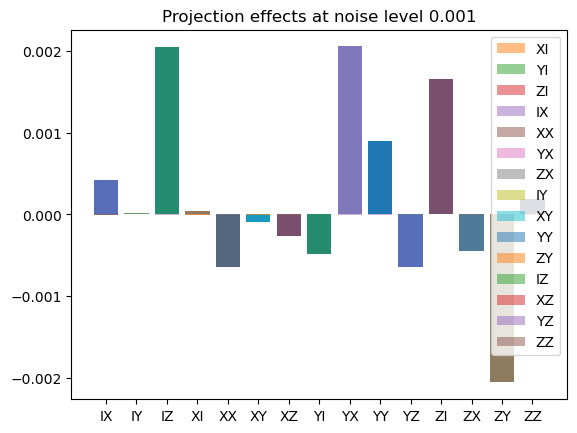

In [167]:
# plot the effects of all 15 projection sequences on the error xvector of the unitary
x = 0.001*np.random.randn(15)
fig, ax = plt.subplots()
ax.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())
for key in PROJECTION_TRIPLETS.keys():
    U = compile_projection_sequence_unitary(x, PROJECTION_TRIPLETS[key])
    x_proj = vector_from_SU4(U)/8
    plt.bar(parse_su4_vector(x_proj).keys(), parse_su4_vector(x_proj).values(), alpha=0.5, label=key)
plt.legend()
plt.title("Projection effects at noise level 0.001")
plt.show()


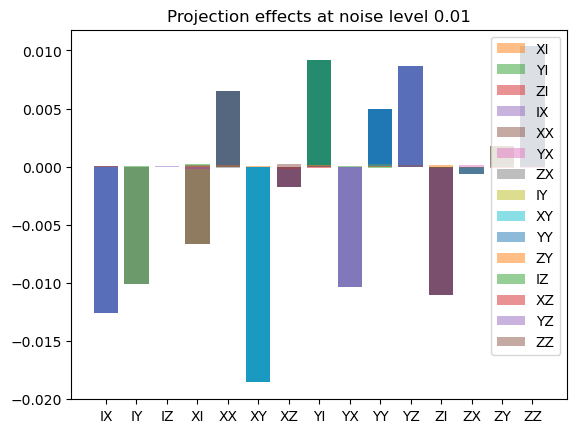

In [168]:
# plot the effects of all 15 projection sequences on the error xvector of the unitary
x = 0.01*np.random.randn(15)
fig, ax = plt.subplots()
ax.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())
for key in PROJECTION_TRIPLETS.keys():
    U = compile_projection_sequence_unitary(x, PROJECTION_TRIPLETS[key])
    x_proj = vector_from_SU4(U)/8
    plt.bar(parse_su4_vector(x_proj).keys(), parse_su4_vector(x_proj).values(), alpha=0.5, label=key)
plt.legend()
plt.title("Projection effects at noise level 0.01")
plt.show()

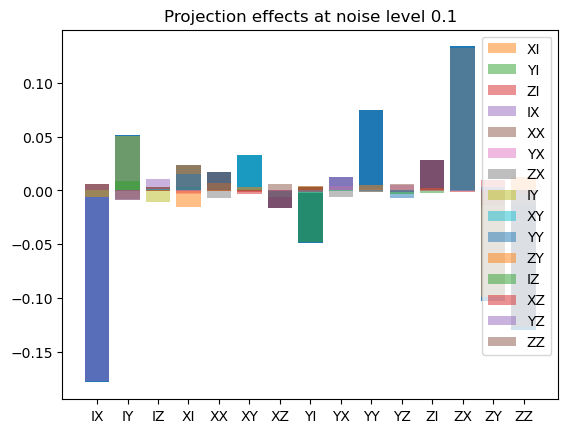

In [169]:
# plot the effects of all 15 projection sequences on the error xvector of the unitary
x = 0.1*np.random.randn(15)
fig, ax = plt.subplots()
ax.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())
for key in PROJECTION_TRIPLETS.keys():
    U = compile_projection_sequence_unitary(x, PROJECTION_TRIPLETS[key])
    x_proj = vector_from_SU4(U)/8
    plt.bar(parse_su4_vector(x_proj).keys(), parse_su4_vector(x_proj).values(), alpha=0.5, label=key)
plt.legend()
plt.title("Projection effects at noise level 0.1")
plt.show()

# Repeated projection sequences

In [204]:
def make_proj_x_at_depth(x, pauli_projector_triplet, depth):
    U = compile_projection_sequence_unitary(x, pauli_projector_triplet)
    U_power = matrix_power(U, depth)
    return vector_from_SU4(U_power)/(8*depth)

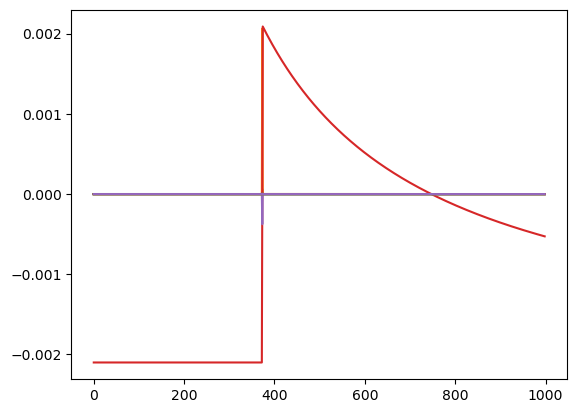

In [205]:
# now, I'll stick with the noise level of 0.01 and investigate the effects of repeated projections
x = 0.001*np.random.randn(15)

fig, ax = plt.subplots()

x_proj_sequence = [make_proj_x_at_depth(x, PROJECTION_TRIPLETS['XI'], d) for d in range(1, 1000)]
plt.plot(x_proj_sequence)

# Cartan signals

An eigenbasis signal is measured by the in-phase and quadrature state preparations and measurements. For each unitary, there are 6 distinct pairs of eigen-states

In [206]:
def inphase_preparations(pauli_string):
    U = pauli_string_to_SU4(pauli_string)
    eigenvecs = np.linalg.eig(U)[1]
    all_pair_indices = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    all_preparation_pairs = {}
    for pair in all_pair_indices:
        prep1 = eigenvecs[:, pair[0]]
        prep2 = eigenvecs[:, pair[1]]
        all_preparation_pairs[(pair[0], pair[1])] = (prep1 + prep2)/np.sqrt(2)
    return all_preparation_pairs

def quadrature_preparations(pauli_string):
    U = pauli_string_to_SU4(pauli_string)
    eigenvecs = np.linalg.eig(U)[1]
    all_pair_indices = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    all_preparation_pairs = {}
    for pair in all_pair_indices:
        prep1 = eigenvecs[:, pair[0]]
        prep2 = eigenvecs[:, pair[1]]
        all_preparation_pairs[(pair[0], pair[1])] = (prep1 + 1j*prep2)/np.sqrt(2)
    return all_preparation_pairs

In [207]:
inphase_preps = inphase_preparations('XI')
quadrature_preps = quadrature_preparations('XI')

In [208]:
def plot_complex_signal(x, target_twirl_subspace, eigen_pair, depths, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    pauli_projection_triplet = PROJECTION_TRIPLETS[target_twirl_subspace]
    U = compile_projection_sequence_unitary(x, pauli_projection_triplet)
    inphase_prep = inphase_preparations(target_twirl_subspace)[eigen_pair]
    quadrature_prep = quadrature_preparations(target_twirl_subspace)[eigen_pair]
    inphase_probs = []
    quadrature_probs = []
    for depth in depths:
        U_power = matrix_power(U, depth)
        inphase_probs.append( np.abs(np.vdot(inphase_prep.conj().T, U_power @ inphase_prep))**2 )
        quadrature_probs.append( np.abs(np.vdot(inphase_prep.conj().T, U_power @ quadrature_prep))**2 )
    inphase_signal = 1 - 2*np.array(inphase_probs)
    quadrature_signal = 1 - 2*np.array(quadrature_probs)
    # plot the inphase and quadrature on the real and imaginary axes, use color to indicate depth
    ax.scatter(inphase_signal, quadrature_signal, c=depths)
    # draw the complex unit circle
    circle = patches.Circle((0, 0), 1, fill=False)
    ax.add_patch(circle)

def plot_cartan_phases(x, target_twirl_subpsace, depths):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    for idx, eigen_pair in enumerate([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]):
        plot_complex_signal(x, target_twirl_subpsace, eigen_pair, depths, ax=ax.flatten()[idx])
        ax.flatten()[idx].set_title(f"Cartan phase {eigen_pair}")
    

<BarContainer object of 15 artists>

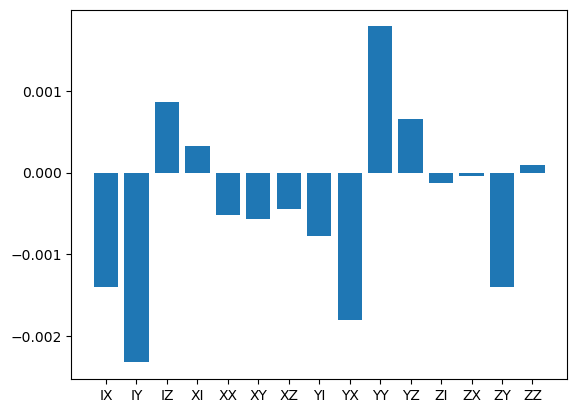

In [209]:
x = 0.001*np.random.randn(15)
plt.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())

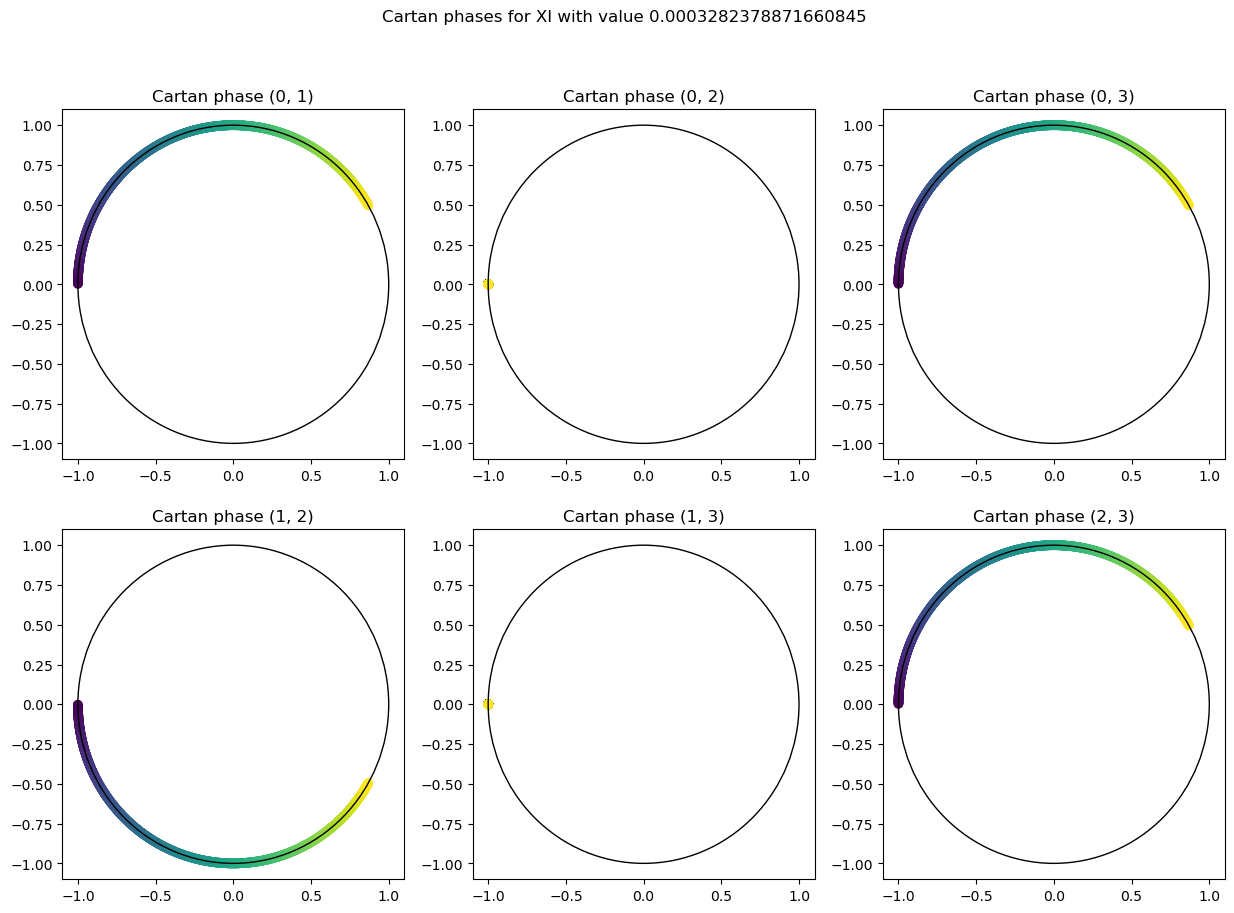

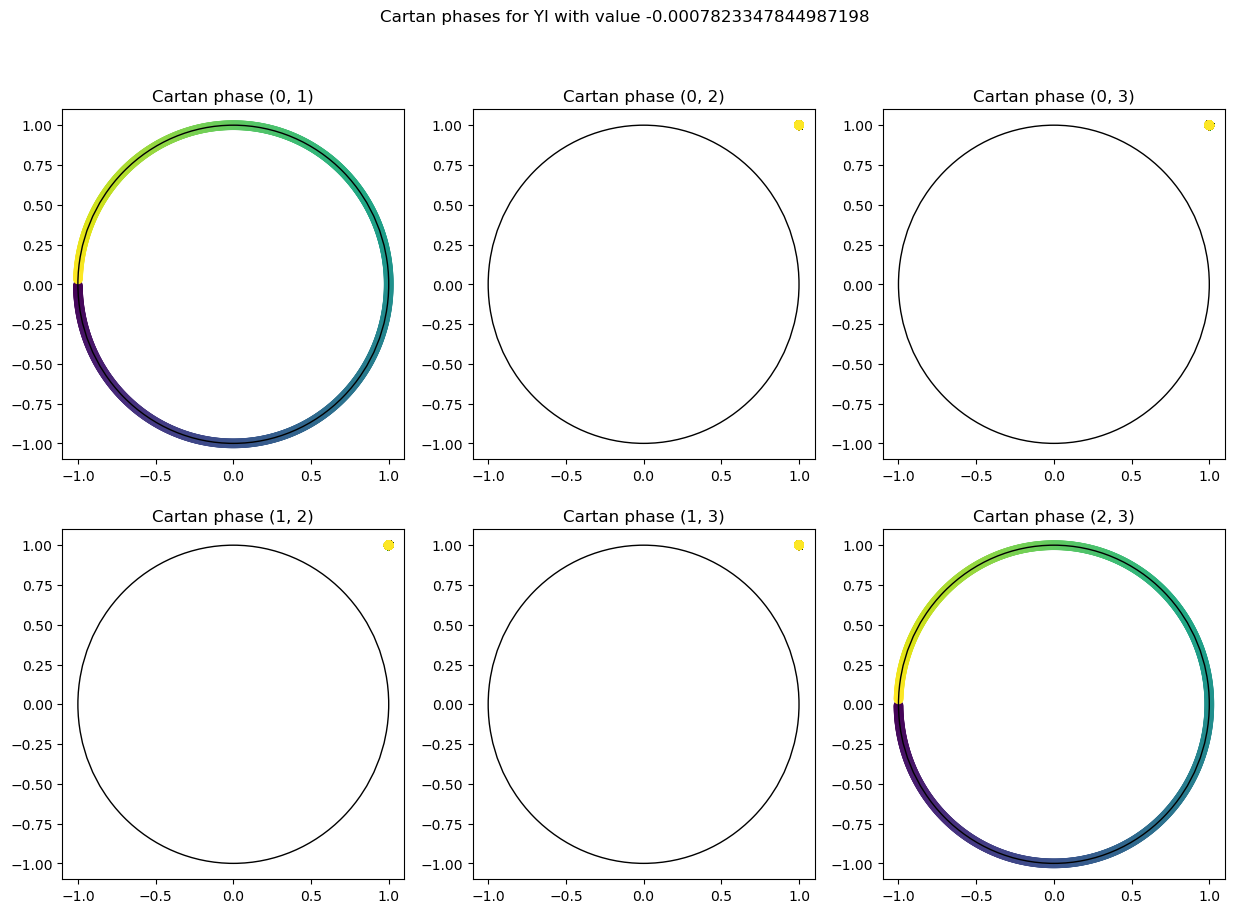

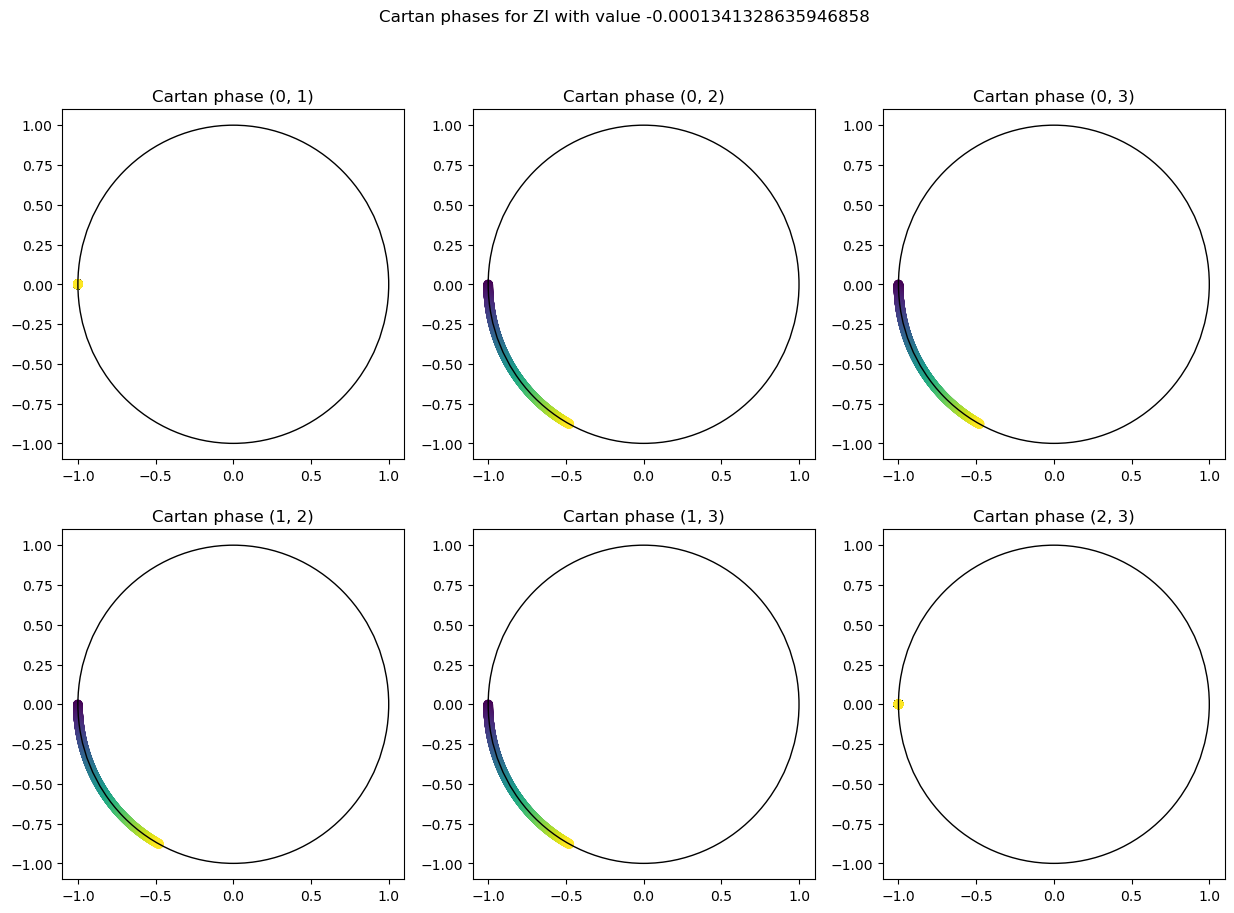

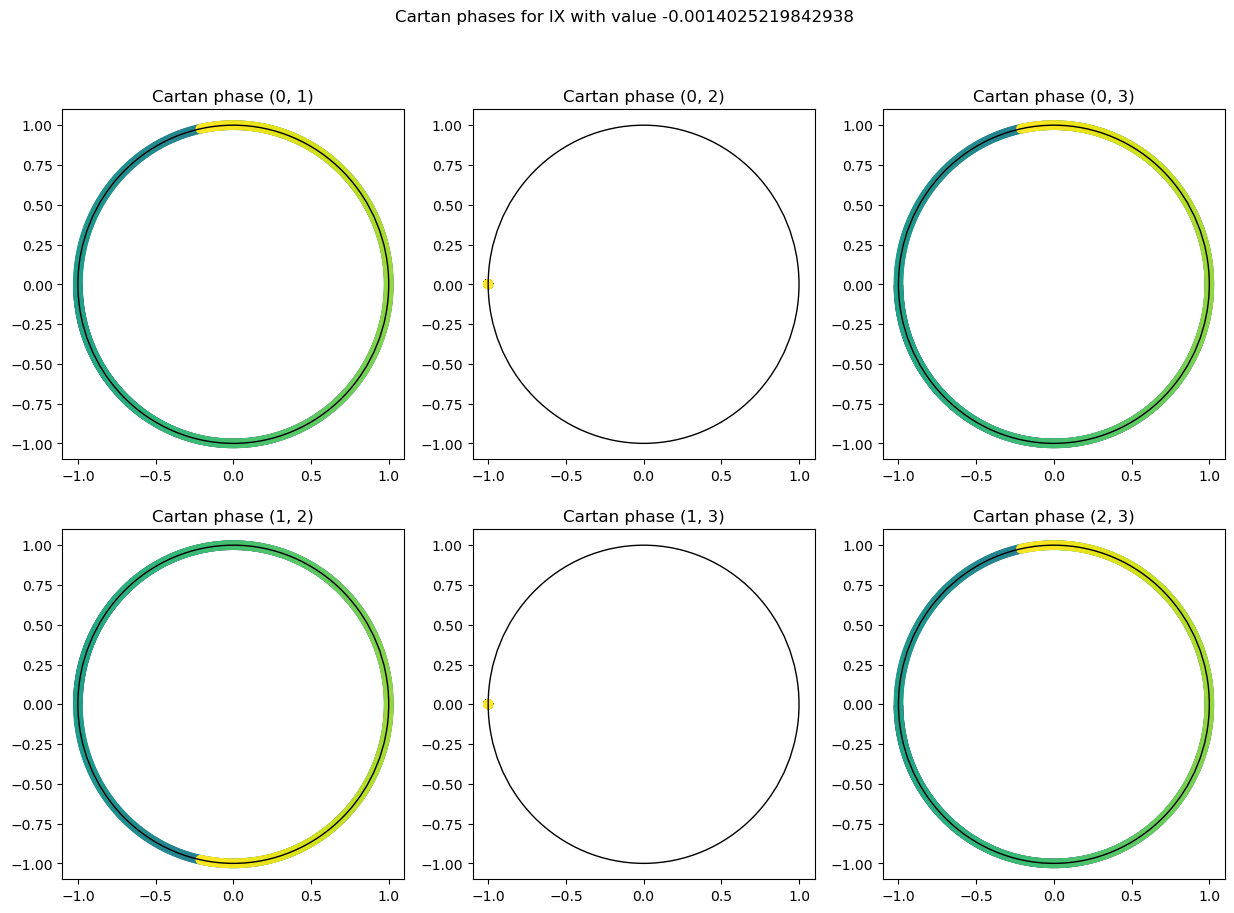

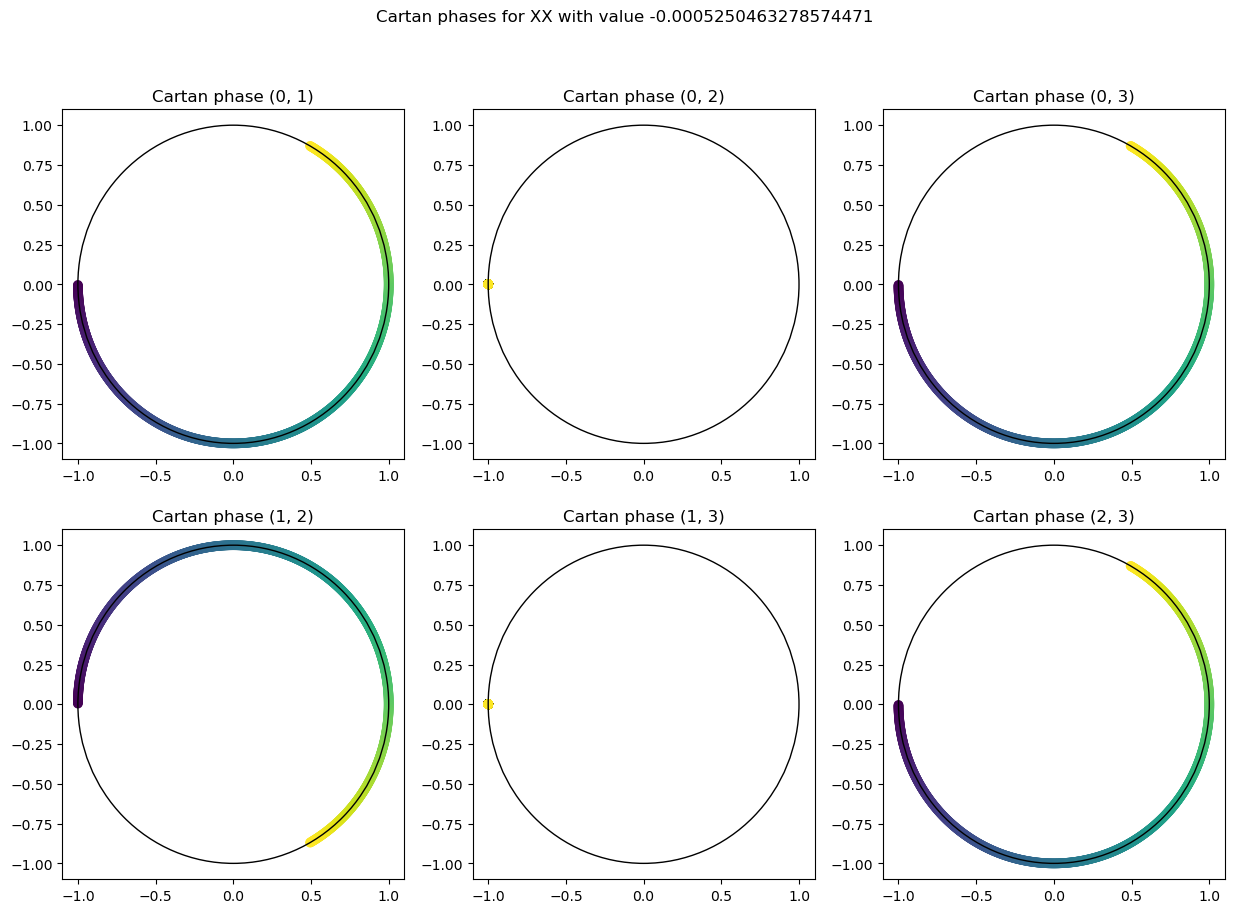

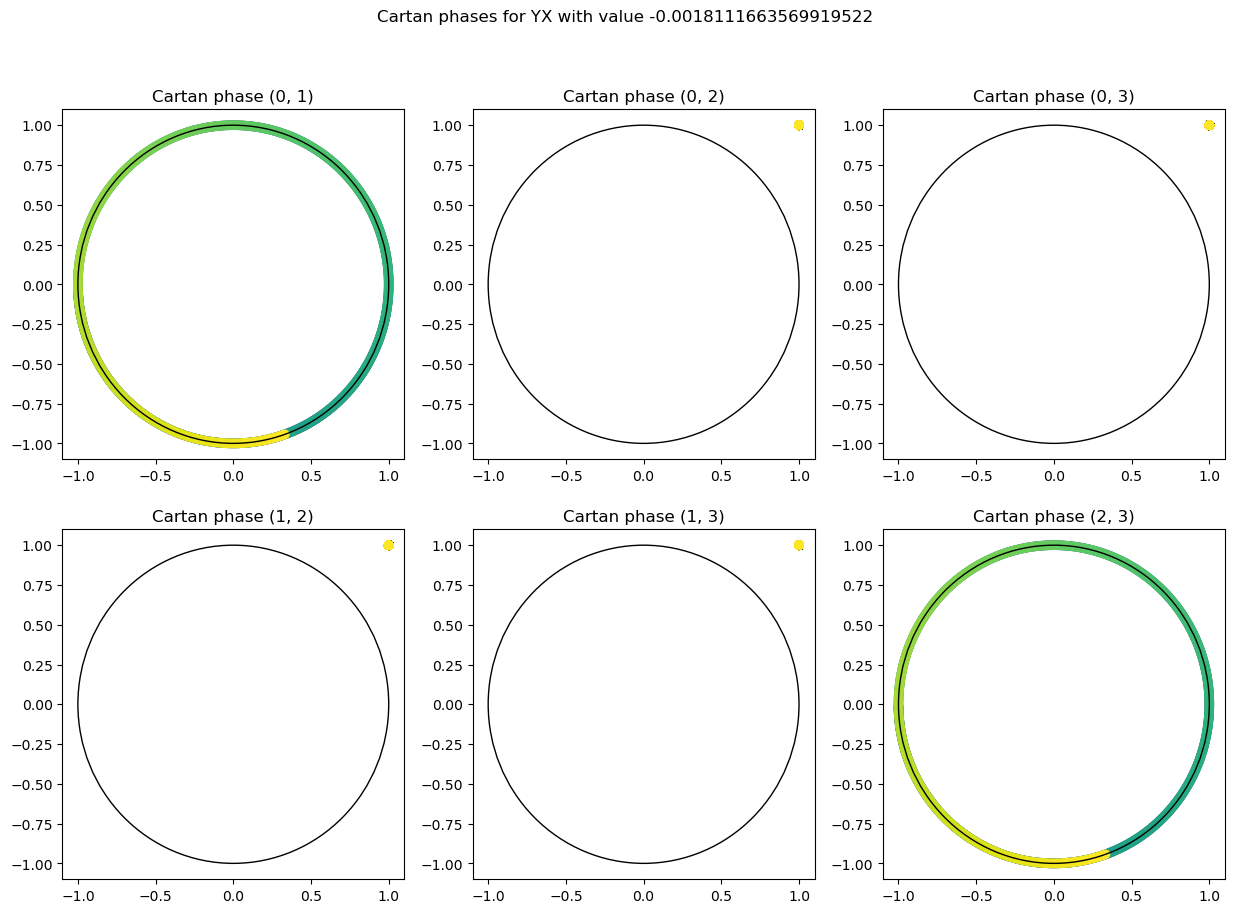

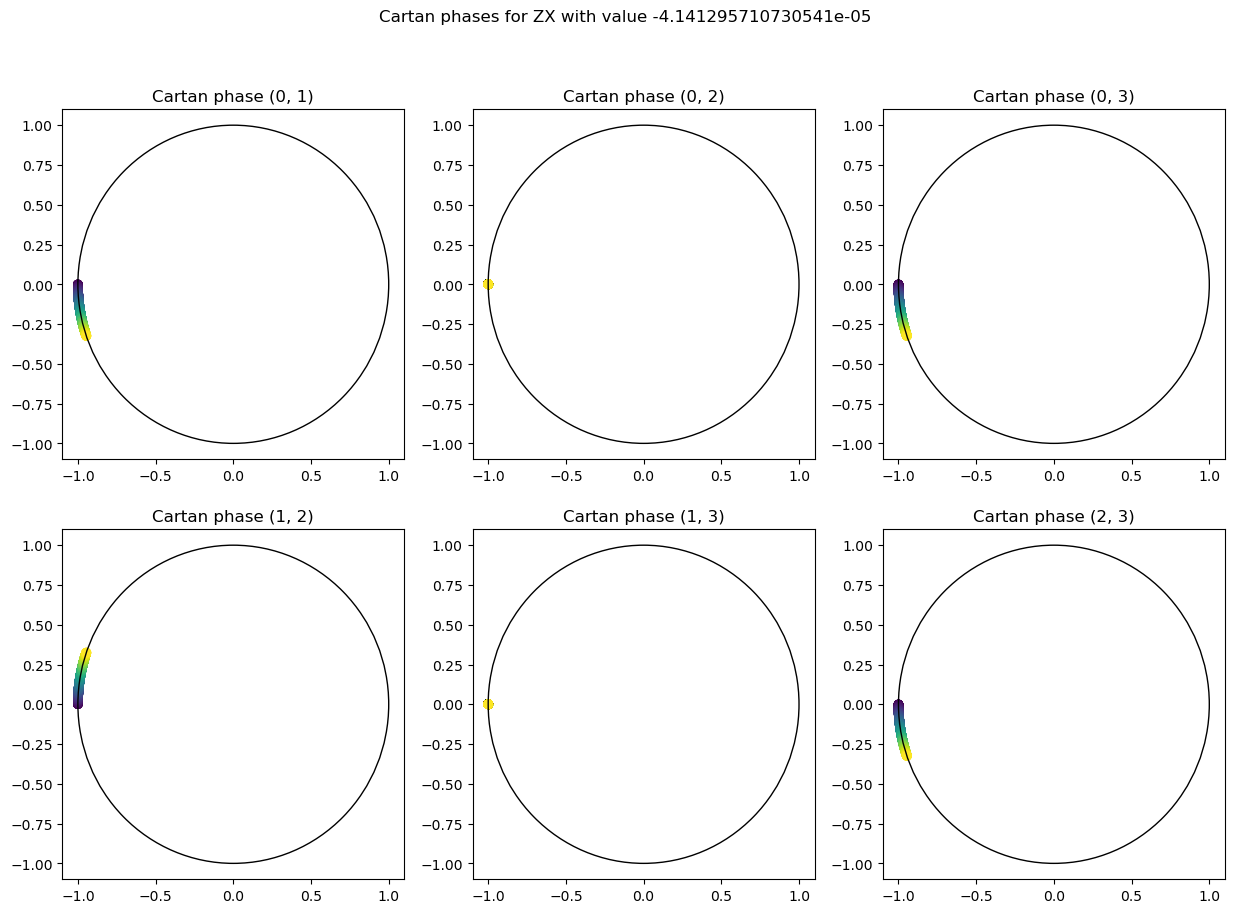

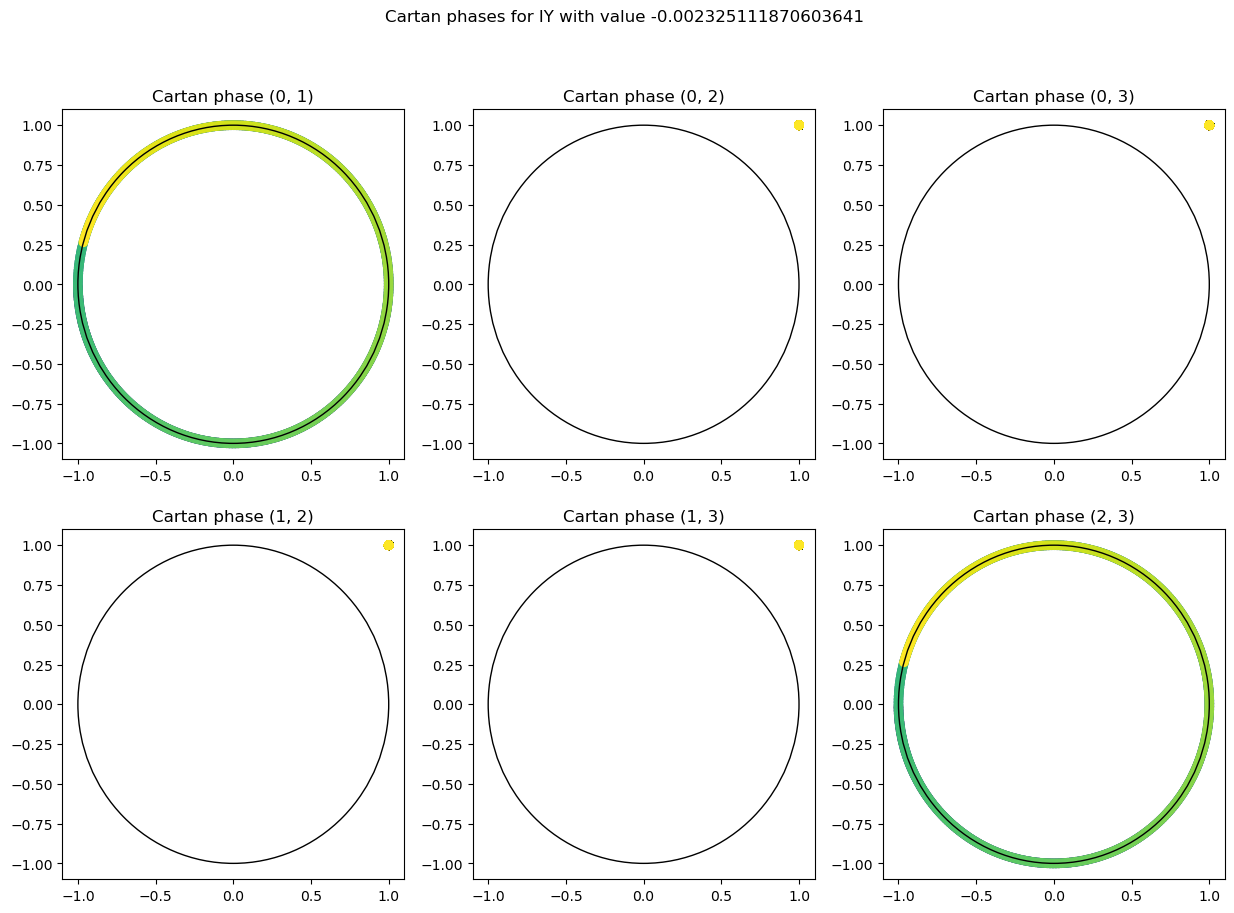

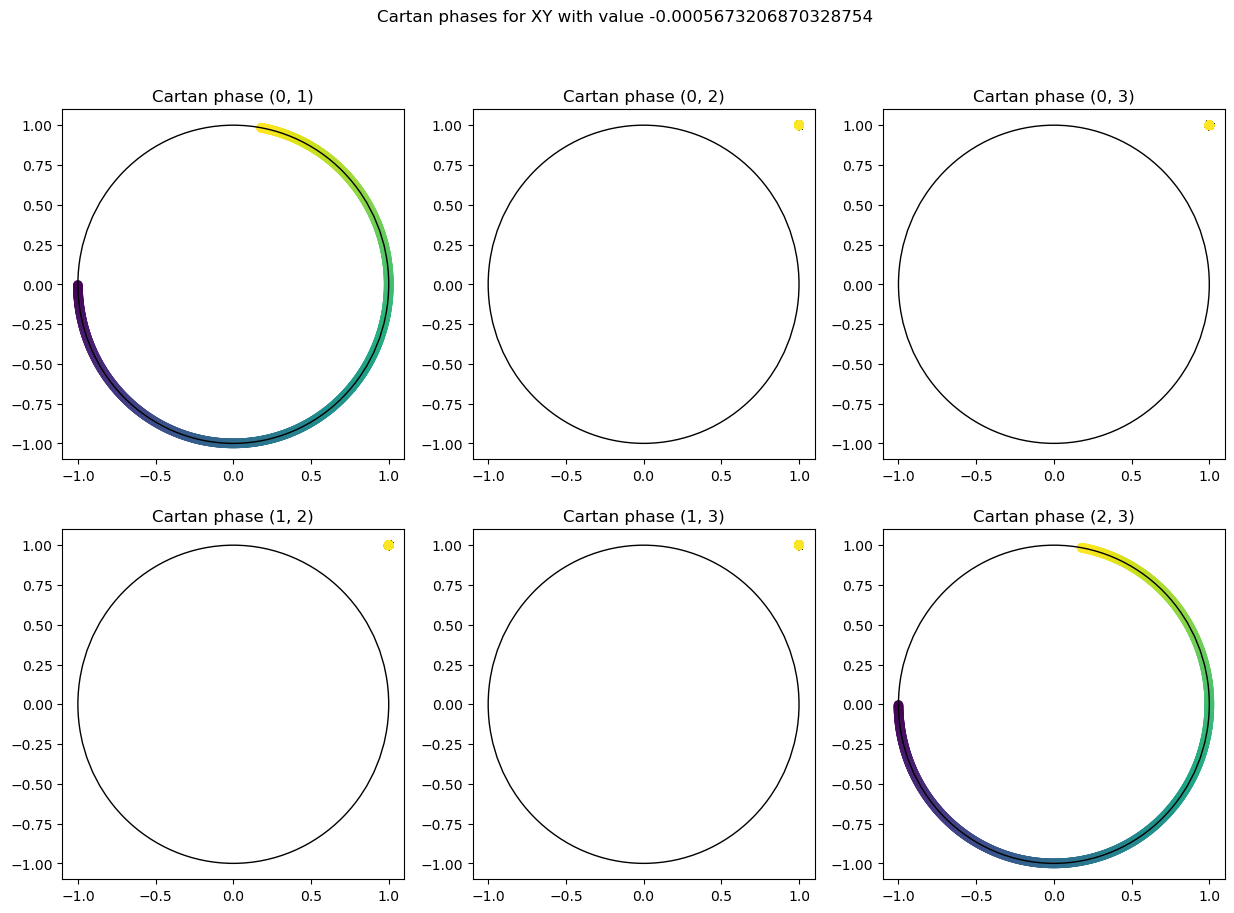

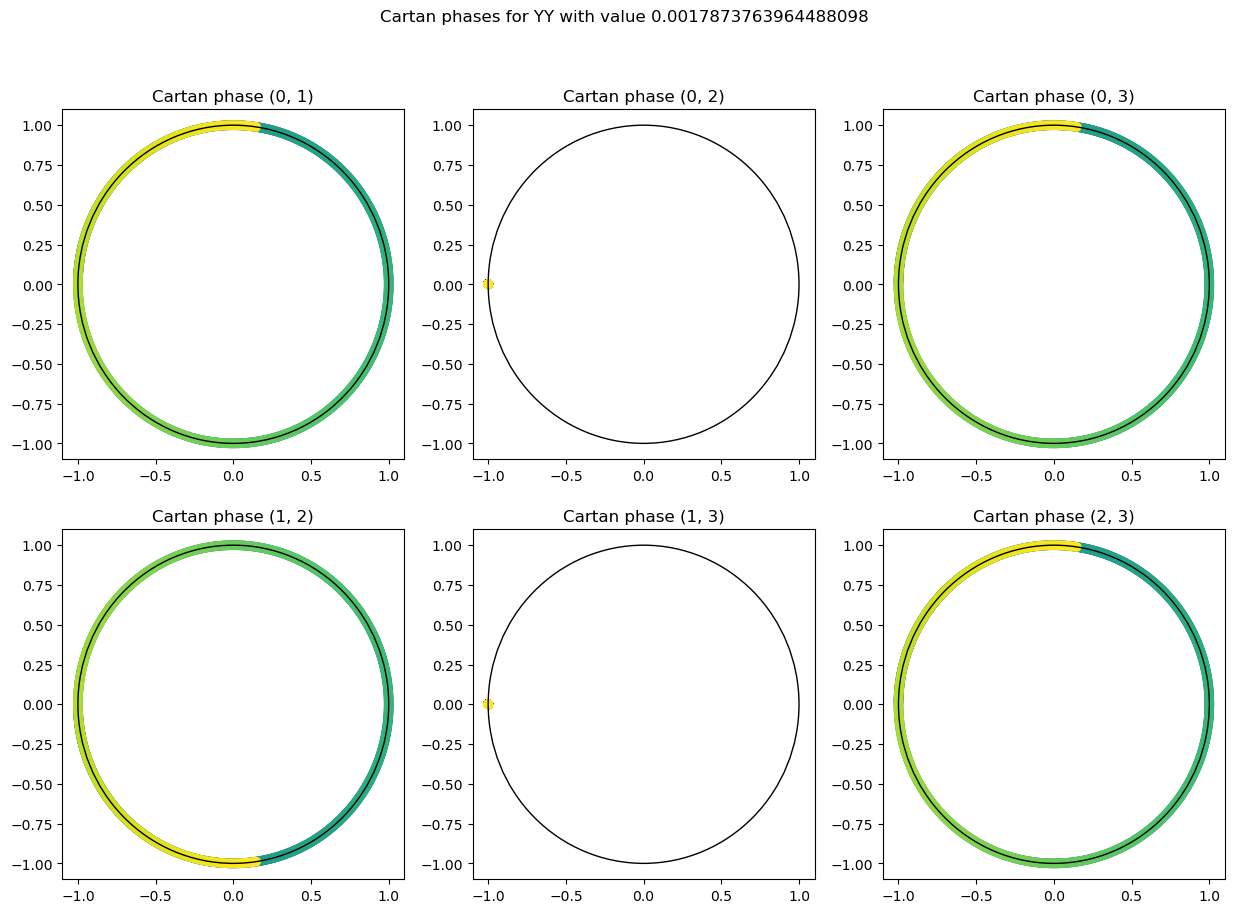

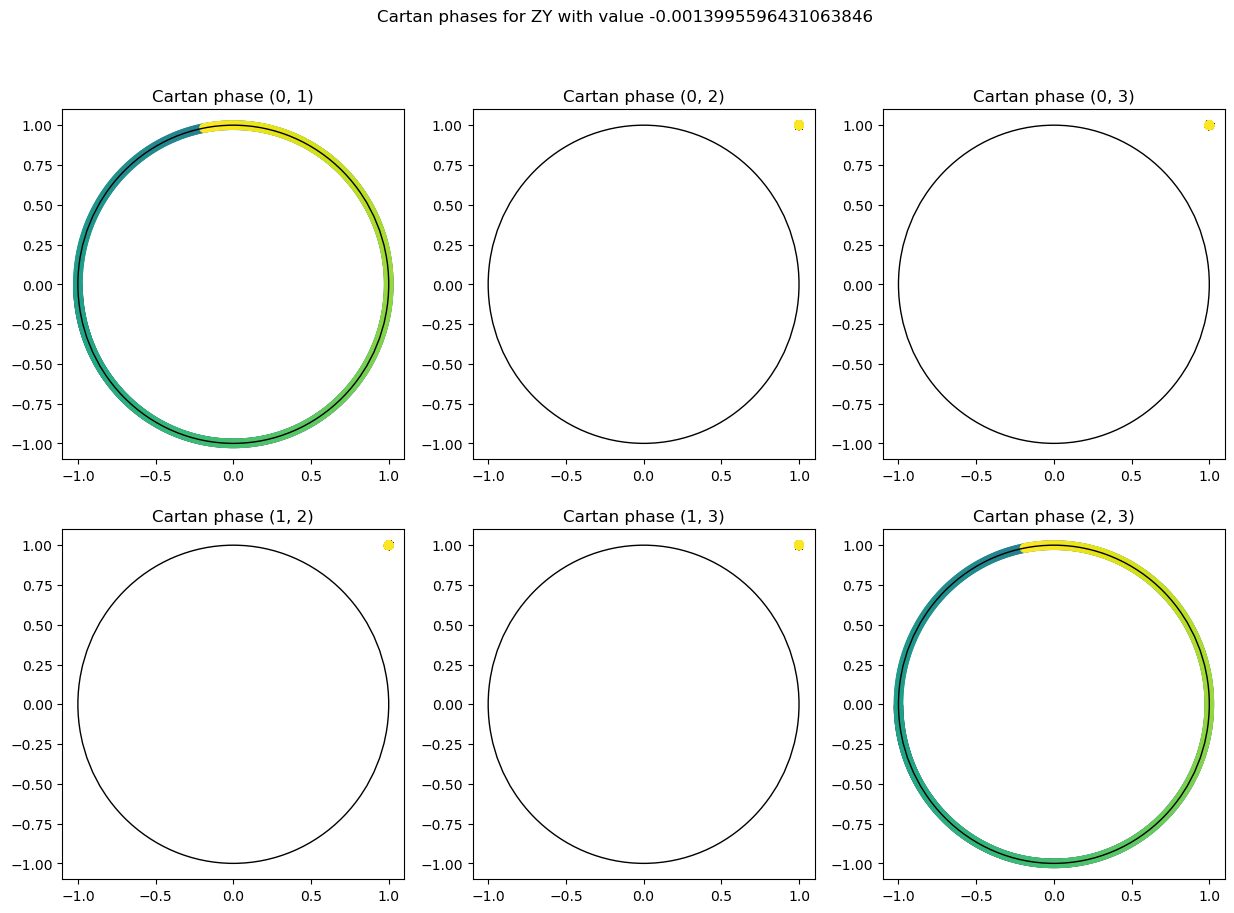

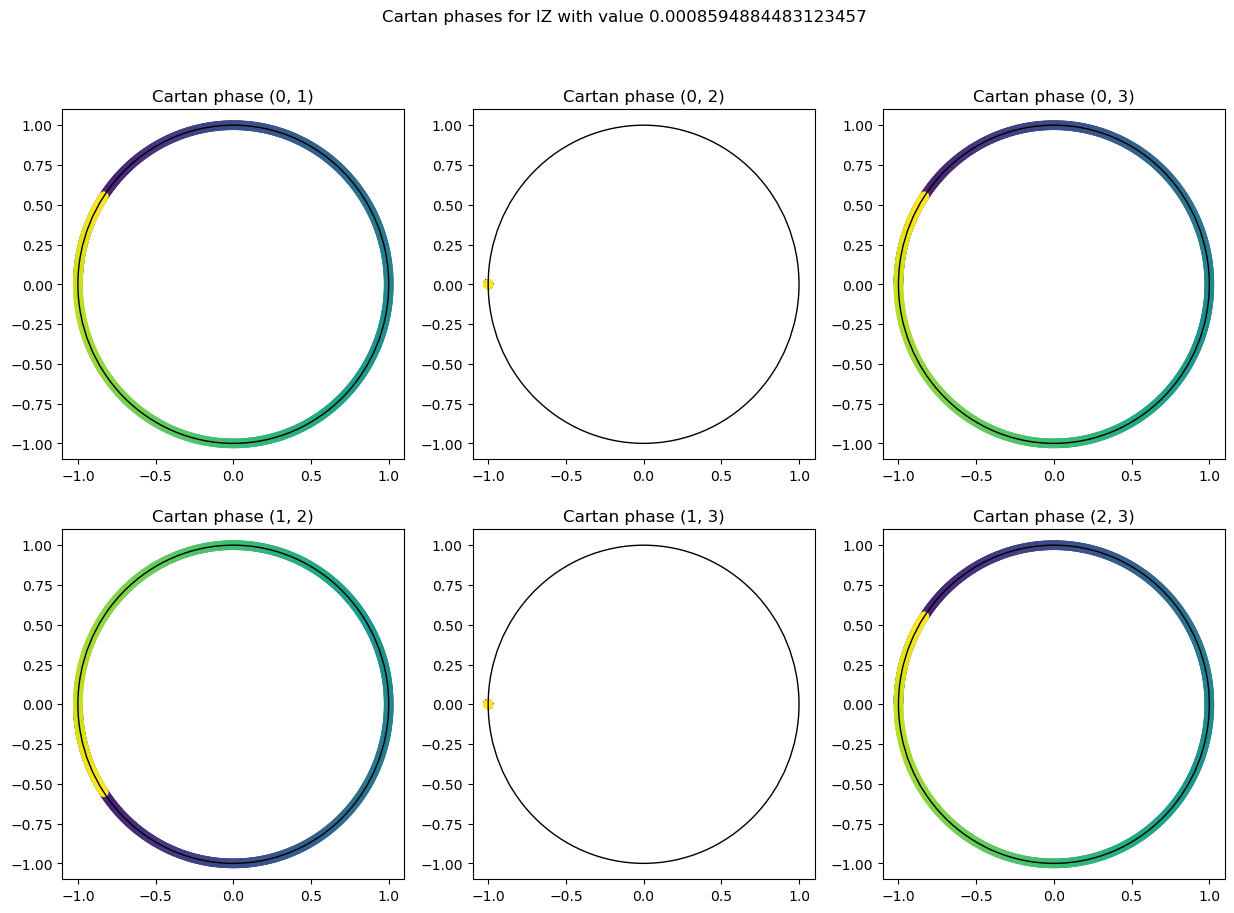

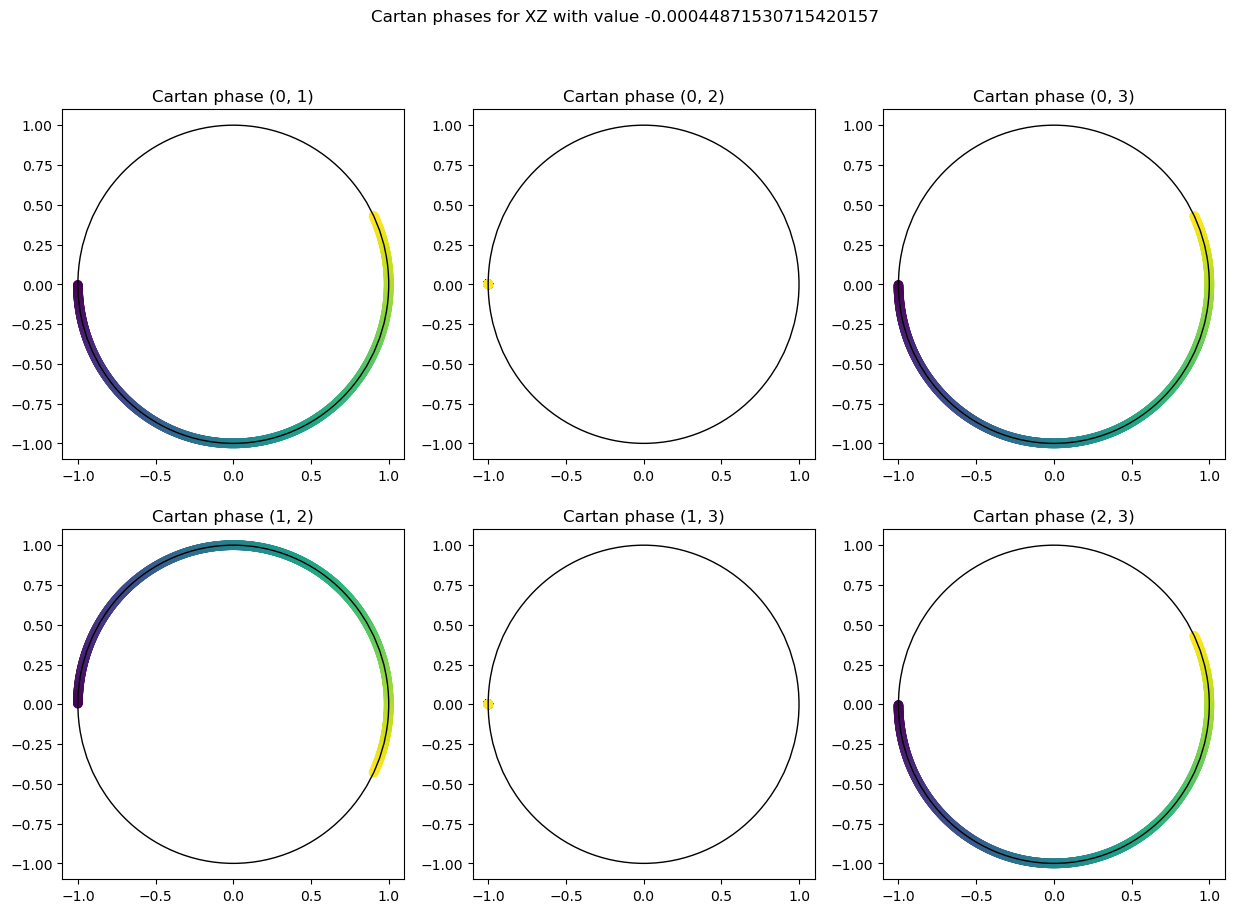

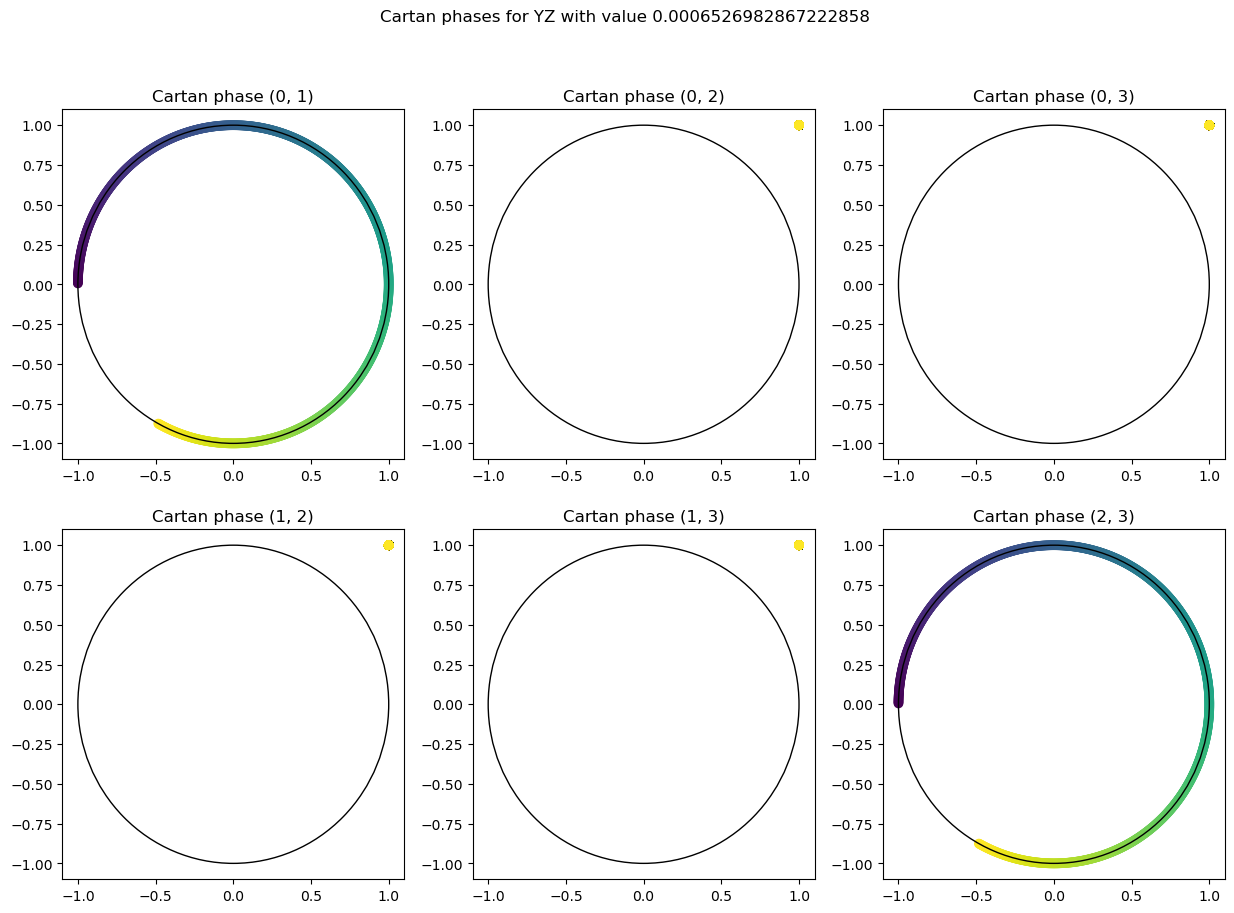

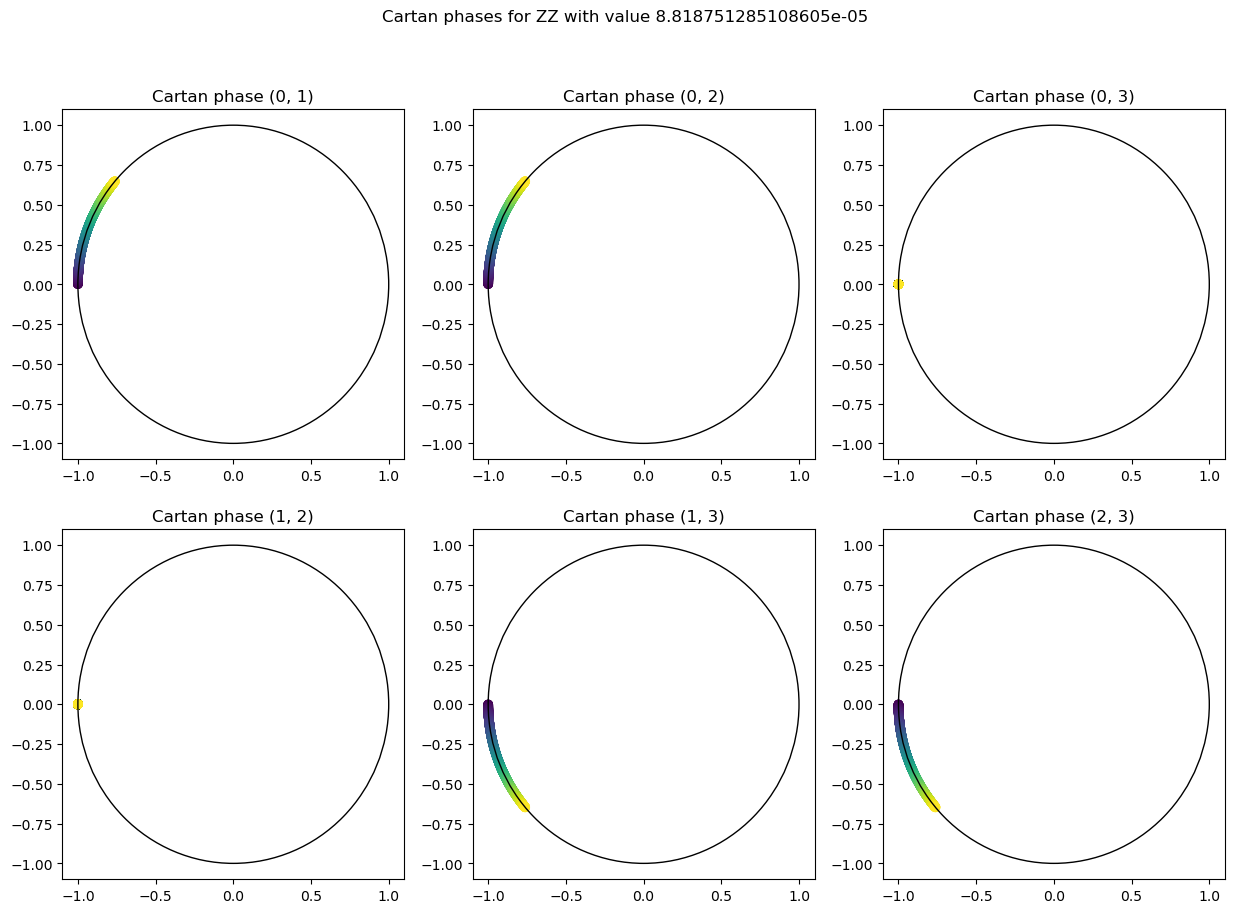

In [210]:
depths = np.arange(1, 1000)
for key in PROJECTION_TRIPLETS.keys():
    plot_cartan_phases(x, key, depths)
    plt.suptitle(f"Cartan phases for {key} with value {parse_su4_vector(x)[key]}")
    plt.show()
